In [249]:
!pip install pytube
!pip install ffmpeg-python
!pip install transformers
!pip install PIL
!pip install torchvision
!pip install easyocr

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [250]:
!pip install session-info

In [251]:
import session_info
session_info.show()

In [252]:
from pytube import YouTube

In [253]:
yt = YouTube('https://www.youtube.com/watch?v=T-gAeX-9_3M')

yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(filename="currency.mp4")

'/workspace/currency-updater/currency.mp4'

In [254]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="currency.mp4" type="video/mp4">
    </video>
""")

# Extracting Image from video

In [255]:
import ffmpeg
YOUR_FILE = 'currency.mp4'
probe = ffmpeg.probe(YOUR_FILE)
time = float(probe['streams'][0]['duration']) // 2
width = probe['streams'][0]['width']

parts = 1

intervals = time // parts
intervals = int(intervals)
interval_list = [(i * intervals, (i + 1) * intervals) for i in range(parts)]
i = 0

interval_list

for item in interval_list:
    (
        ffmpeg
        .input(YOUR_FILE, ss=item[1])
        .filter('crop','in_h-100','in_h-200','395','250')
        # .filter('scale', width, -1)
        .output('Image' + str(i) + '.jpg', vframes=1)
        .overwrite_output()
        .run()
    )
    i += 1

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

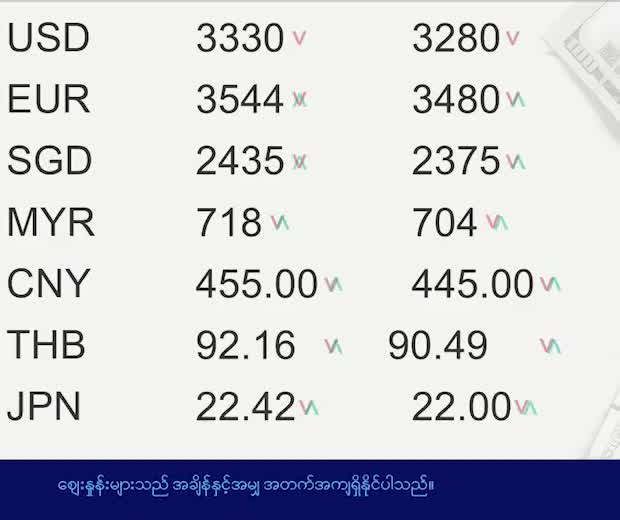

In [257]:
from IPython.display import HTML

image = Image.open("Image0.jpg").convert("RGB")
image

# Draw Lines on the picture to get actual table

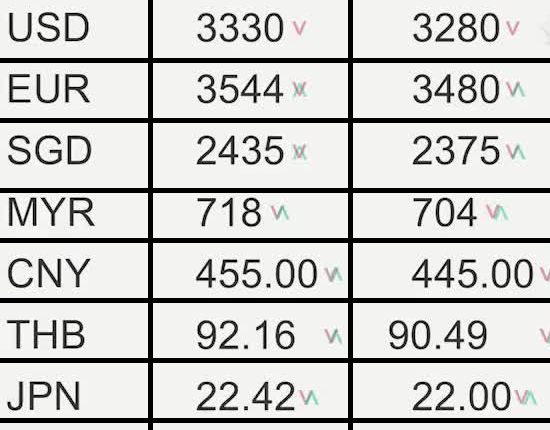

In [258]:
from PIL import Image, ImageDraw
image = Image.open("Image0.jpg").convert("RGB")
# im = Image.new('RGBA', (400, 400), (0, 255, 0, 255)) 
draw = ImageDraw.Draw(image) 
line_color="#000"


draw.line((1500,70, 0,70), fill=line_color,width = 5 )
draw.line((1500,130, 0,130), fill=line_color,width = 5)
draw.line((1500,200, 0,200), fill=line_color,width = 5)
draw.line((1500,250, 0,250), fill=line_color,width = 5)
draw.line((1500,310, 0,310), fill=line_color,width = 5)
draw.line((1500,370, 0,370), fill=line_color,width = 5)
draw.line((1500,430, 0,430), fill=line_color,width = 5)

draw.line((150,1000, 150,0), fill=line_color,width = 5)
draw.line((350,1000, 350,0), fill=line_color,width = 5)

image = image.crop((0, 10, 550, 440))
# img.show()


image

# Calculate Cell location using microsoft/table-structure-recognition-v1.1-all

In [259]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from torchvision import transforms
# hidde logs

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects
     
# Load our model from Hugging Face
from transformers import TableTransformerForObjectDetection

device = "cpu" if torch.cuda.is_available() else "cpu"

# new v1.1 checkpoints require no timm anymore
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
model.to(device)
print("")

In [260]:

structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [261]:
# import PIL.ImageOps 
# image = Image.open("Image0.jpg").convert("RGB")
# image = PIL.ImageOps.invert(image)
pixel_values = structure_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 782, 1000])


# Forward Passing predictions

In [262]:

# forward pass
with torch.no_grad():
  outputs = model(pixel_values)

In [263]:
structure_id2label = model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, image.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9671438336372375, 'bbox': [109.79782104492188, 4.313502788543701, 374.47296142578125, 413.91455078125]}, {'label': 'table projected row header', 'score': 0.8522384762763977, 'bbox': [5.158351421356201, 188.03758239746094, 549.23291015625, 241.69561767578125]}, {'label': 'table row', 'score': 0.9948875308036804, 'bbox': [5.368831634521484, 59.84824752807617, 548.8984375, 124.47518157958984]}, {'label': 'table column', 'score': 0.8940110206604004, 'bbox': [366.3076171875, 3.478208541870117, 549.9757690429688, 413.3446044921875]}, {'label': 'table row', 'score': 0.8898575305938721, 'bbox': [5.5077314376831055, 121.26171875, 548.810546875, 190.26072692871094]}, {'label': 'table row', 'score': 0.9775404334068298, 'bbox': [5.439150333404541, 300.00439453125, 548.8272094726562, 362.64129638671875]}, {'label': 'table row', 'score': 0.9868301749229431, 'bbox': [5.3407206535339355, 184.75111389160156, 549.0317993164062, 239.70664978027344]}, {'label': 'table

# Visualize Predicted Cell locations

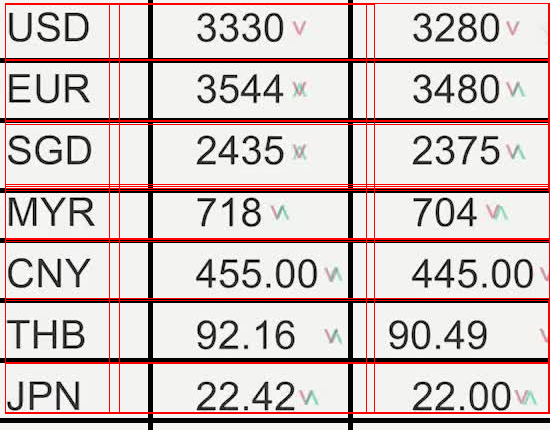

In [265]:
from PIL import ImageDraw

cropped_table_visualized = image.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [266]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [267]:

len(cell_coordinates)

7

In [268]:

for row in cell_coordinates:
  print(row["cells"])

[{'column': [5.429168224334717, 4.03080415725708, 119.40735626220703, 413.35394287109375], 'cell': [5.429168224334717, 3.885215997695923, 119.40735626220703, 60.46049880981445]}, {'column': [109.79782104492188, 4.313502788543701, 374.47296142578125, 413.91455078125], 'cell': [109.79782104492188, 3.885215997695923, 374.47296142578125, 60.46049880981445]}, {'column': [366.3076171875, 3.478208541870117, 549.9757690429688, 413.3446044921875], 'cell': [366.3076171875, 3.885215997695923, 549.9757690429688, 60.46049880981445]}]
[{'column': [5.429168224334717, 4.03080415725708, 119.40735626220703, 413.35394287109375], 'cell': [5.429168224334717, 59.84824752807617, 119.40735626220703, 124.47518157958984]}, {'column': [109.79782104492188, 4.313502788543701, 374.47296142578125, 413.91455078125], 'cell': [109.79782104492188, 59.84824752807617, 374.47296142578125, 124.47518157958984]}, {'column': [366.3076171875, 3.478208541870117, 549.9757690429688, 413.3446044921875], 'cell': [366.3076171875, 59.

# OCR in Action

In [269]:
import numpy as np
import csv
import easyocr
# from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate((cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(image.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)
      
      data[idx] = list(map(lambda x: x.replace('v',''), row_text))

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Max number of columns: 3
['USD', '3330', '3280']
['EUR', '3544', '3480']
['SGD', '2435', '2375']
['MYR', '718 ', '704']
['CNY', '455.00', '445.00']
['THB', '92.16', '90.49']
['JPN', '22.42', '22.00']


In [230]:
from datetime import datetime
import time




# Add timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
epoch_time = time.time()
# Convert list to list of dictionaries with timestamp
json_data = {"data":[{
    "currency": row[0],
    "buy": row[1],
    "sell": row[2]
} for _,row in data.items()],"epoch": epoch_time,"timestamp": timestamp}

# Save as JSON
with open('data.json', 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print("Data saved as 'data.json'")

Data saved as 'data.json'
